In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

covid_de = pd.read_csv('covid_germany/covid_de.csv')
demographics_de = pd.read_csv('covid_germany/demographics_de.csv')

In [314]:
covid_de.head()

,state,county,age_group,gender,date,cases,deaths,recovered
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1


In [315]:
demographics_de.head()

,state,gender,age_group,population
0,Baden-Wuerttemberg,female,00-04,261674
1,Baden-Wuerttemberg,female,05-14,490822
2,Baden-Wuerttemberg,female,15-34,1293488
3,Baden-Wuerttemberg,female,35-59,1919649
4,Baden-Wuerttemberg,female,60-79,1182736


# Data cleaning

In [316]:
covid_de.date = pd.to_datetime(covid_de.date, infer_datetime_format = True)
#convert the date column in the covid dataset to date time format

In [317]:
covid_de.dtypes

state                object
county               object
age_group            object
gender               object
date         datetime64[ns]
cases                 int64
deaths                int64
recovered             int64
dtype: object

## Missing Values

In [318]:
covid_de.isnull().sum()
# check for missing values

state            0
county           0
age_group     2244
gender       13916
date             0
cases            0
deaths           0
recovered        0
dtype: int64

In [319]:
demographics_de.isnull().sum()

state         0
gender        0
age_group     0
population    0
dtype: int64

In [320]:
covid_de[covid_de['gender'].isnull()].head(5)

,state,county,age_group,gender,date,cases,deaths,recovered
315,Baden-Wuerttemberg,LK Alb-Donau-Kreis,05-14,NaN,2020-10-30,1,0,1
316,Baden-Wuerttemberg,LK Alb-Donau-Kreis,05-14,NaN,2020-11-19,1,0,1
798,Baden-Wuerttemberg,LK Alb-Donau-Kreis,15-34,NaN,2020-10-28,1,0,1
799,Baden-Wuerttemberg,LK Alb-Donau-Kreis,15-34,NaN,2020-10-30,2,0,2
800,Baden-Wuerttemberg,LK Alb-Donau-Kreis,15-34,NaN,2020-11-01,1,0,1


In [321]:
covid_de[covid_de['age_group'].isnull()].head(5)

,state,county,age_group,gender,date,cases,deaths,recovered
1919,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,F,2020-10-26,1,0,1
1920,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,F,2020-11-19,1,0,1
1921,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,F,2020-12-24,1,0,1
1922,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,M,2021-03-31,1,0,0
6114,Baden-Wuerttemberg,LK Boeblingen,NaN,M,2021-01-30,1,0,1


In [322]:
covid_de['age_group'].isnull().sum()/len(covid_de) * 100

# only 0.3246%  in the age group column are missing so we can just drop the rows since it is a very small'
# percentages

0.32464056618240633

In [323]:
covid_de['gender'].isnull().sum()/len(covid_de) * 100
# only 2.01% of the entries in the gender column column are missing so we can just drop the rows since it is a very small
# percentages

2.0132344558798425

In [368]:
# drop missing rows in age group rows
covid_de = covid_de[covid_de['age_group'].notna()]

In [369]:
# drop missing rows in gender group rows
covid_df = covid_de[covid_de['gender'].notna()]

In [370]:
covid_df.isnull().sum()

state        0
county       0
age_group    0
gender       0
date         0
cases        0
deaths       0
recovered    0
dtype: int64

## Duplicates

In [371]:
print('number of duplicated rows in "covid" :', covid_df.duplicated().sum())
print('')
print('number of duplicated rows in "demographics" :', demographics_de.duplicated().sum())

number of duplicated rows in "covid" : 0

number of duplicated rows in "demographics" : 0


In [372]:
covid_df[covid_df.duplicated(keep=False)].head()

,state,county,age_group,gender,date,cases,deaths,recovered


In [373]:
# drop duplicate entries
covid_df = covid_df.drop_duplicates()
print('number of duplicated rows in "covid" :', covid_df.duplicated().sum())

number of duplicated rows in "covid" : 0


## Outliers

<AxesSubplot:>

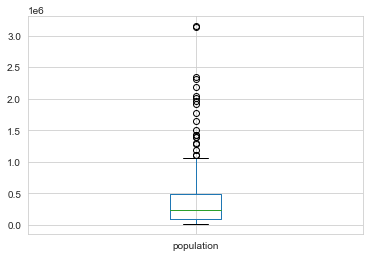

In [374]:
demographics_de.boxplot()

In [375]:
def outliers_loc(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    ind = df.index[(df[feature] <= lower_bound) | (df[feature] >= upper_bound)]
    return ind

# function to detect location of outliers using Interquartile range

In [376]:
def remove_out(df, indexes_ls):
    out_index_ls = sorted(set(indexes_ls))
    df = df.drop(out_index_ls)
    return df
# function to remove outliers given the location of the outliers

In [377]:
outlrs_loc = outliers_loc(demographics_de, 'population')
print('number of outliers in "demographics_de" :', len(outlrs_loc))

number of outliers in "demographics_de" : 21


In [378]:
new_demographics_cleaned =  remove_out(demographics_de, outlrs_loc)

<AxesSubplot:>

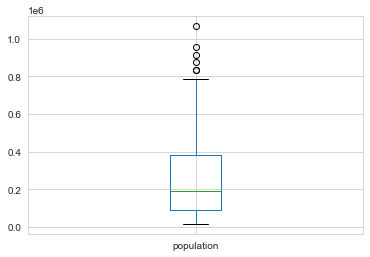

In [379]:
new_demographics_cleaned.boxplot()
# most of the outliers have been removed only few left

<AxesSubplot:>

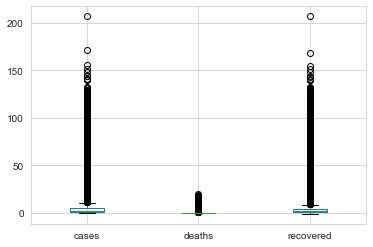

In [380]:
covid_df.boxplot()

In [381]:
outlrs_indexes = outliers_loc(covid_df, 'cases')

In [382]:
new_covid_df_cleaned =  remove_out(covid_df, outlrs_indexes)

<AxesSubplot:>

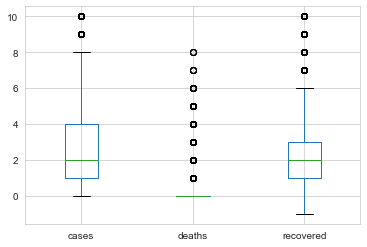

In [383]:
new_covid_df_cleaned.boxplot()

In [384]:
new_demographics_cleaned = new_demographics_cleaned.replace(['female', 'male'], ['F', 'M'])

In [385]:
merged_data = new_covid_df_cleaned.merge(new_demographics_cleaned,
                                         how = 'inner', on = ['state', 'gender', 'age_group'])

# merge the cleaned demographics and covid dataset

In [386]:
merged_data.shape

(385640, 9)

__final data sets new_covid_df_cleaned, new_demographics_cleaned and merged_data__

# Data Analysis

## Covid cases trend in Germany

In [387]:
covidcases_bydate = new_covid_df_cleaned.groupby('date').sum()

In [388]:
covidcases_bydate.head()

,cases,deaths,recovered
date,,,
2020-01-07,1,0,1
2020-01-19,1,0,1
2020-01-23,1,0,1
2020-01-25,1,0,1
2020-01-28,2,0,2


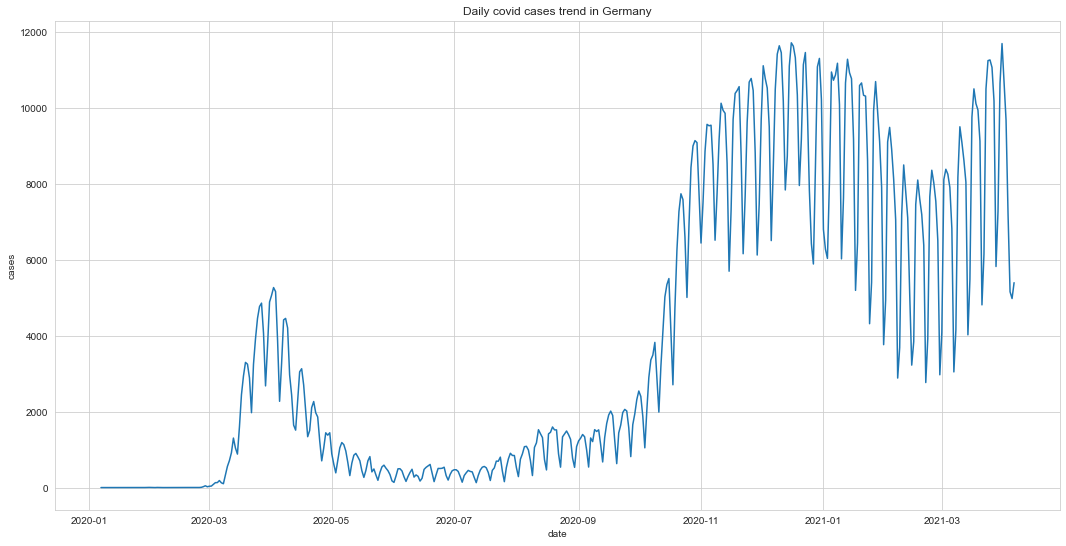

In [389]:
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
plt.figure(figsize=(18,9))
plt.title('Daily covid cases trend in Germany')
p=sns.lineplot(data=covidcases_bydate.cases)

* From the graph above it looks like the number of cases peaked near the start of 2021.
* Moreover it also looks like in april there was a second wave of surge of number of cases

## Trend by states

In [390]:
covid_bystate = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()

In [391]:
covid_bystate.reset_index(inplace=True)

In [392]:
covid_bystate.head()

,state,date,cases,deaths,recovered
0,Baden-Wuerttemberg,2020-02-24,1,0,1
1,Baden-Wuerttemberg,2020-02-25,2,0,2
2,Baden-Wuerttemberg,2020-02-26,4,0,4
3,Baden-Wuerttemberg,2020-02-27,3,0,3
4,Baden-Wuerttemberg,2020-02-28,7,0,7


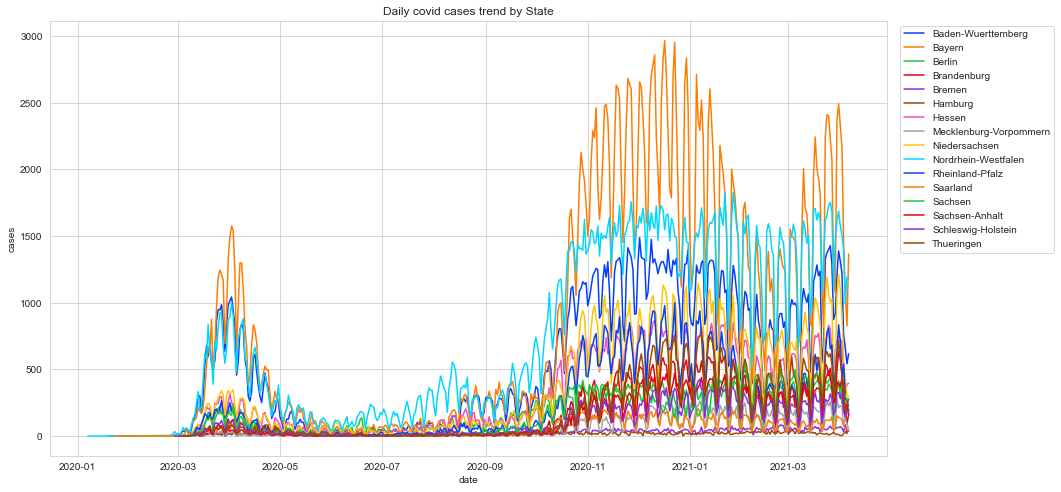

In [393]:
plt.figure(figsize=(15,8))
ln = sns.lineplot(data=covid_bystate, x="date", y="cases", hue="state", palette = 'bright')
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Daily covid cases trend by State")
plt.show()

* from the graph above one can see that in the peak monnths Bayern contributed more in the rise of cases in Germany
* however just comparing the numbers can be misleading because population sizes also plays a key part so it is bettter to compare the ratios population

In [394]:
cov_demo_df = merged_data.copy()

cov_demo_df['Cases per population'] = merged_data.cases/merged_data.population

In [395]:
state_data = cov_demo_df.groupby('state').sum().sort_values('Cases per population', ascending=False)

In [396]:
state_data.head()

,cases,deaths,recovered,population,Cases per population
state,,,,,
Thueringen,75904,2922,67032,6242867987,0.438883
Brandenburg,65225,2678,57138,6002839509,0.326002
Saarland,24061,732,22147,936841656,0.312279
Sachsen-Anhalt,52541,2021,45324,4043605652,0.306906
Rheinland-Pfalz,104470,2958,93558,19854720609,0.299543


[]

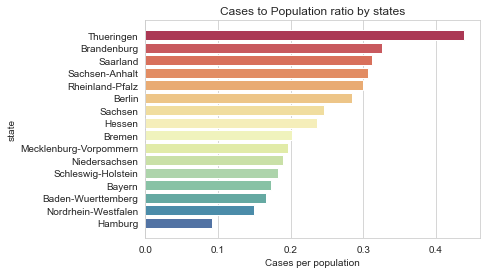

In [397]:
sns.barplot(data = state_data, x='Cases per population', y=state_data.index, palette='Spectral')
plt.title("Cases to Population ratio by states")
plt.plot()

* From the graph above one can see the full story that although Bayern contributed more to the spike in covid cases because it has a larger population but when we compare cases to population ratio bayern is one of the botton 4 but Thueringen had the highest.

## Rates

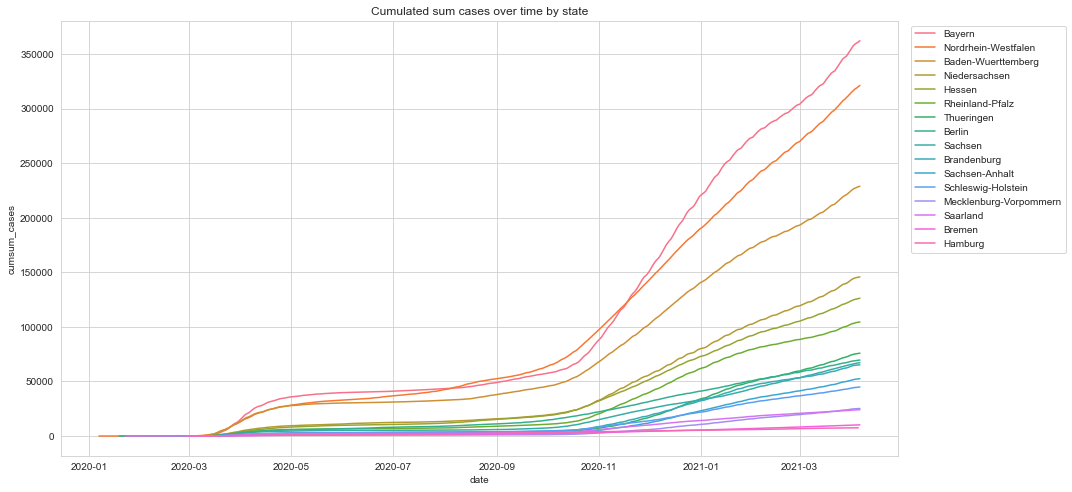

In [398]:
state_sum = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()
state_sum = state_sum.replace([np.inf, -np.inf], 0)
state_sum["cumsum_cases"] = state_sum.groupby(level=-2)["cases"].cumsum()
state_sum = state_sum.reset_index()

plt.figure(figsize=(15,8))
ln = sns.lineplot(data=state_sum.sort_values("cumsum_cases", ascending=False), x="date", y="cumsum_cases", hue="state")
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Cumulated sum cases over time by state")
plt.show()

* from the graph above one can see that Bayern had the highest increasing rate and Hamburg had the lowest increasing rate

# Modeling

In [399]:
cov_model_df = new_covid_df_cleaned.groupby(by=["state", "county", 'age_group', 'gender']).sum()
# calculate the sum of cases deaths and recovered and cases for each gender, age_group, county and state

In [400]:
cov_model_df.reset_index(inplace=True)

In [401]:
new_merged = cov_model_df.merge(new_demographics_cleaned,
                                         how = 'inner', on = ['state', 'gender', 'age_group'])
# merge the demographics data in order to obtain population

In [451]:
new_merged.head()

,state,county,age_group,gender,cases,deaths,recovered,population
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,1,49,0,41,261674
1,Baden-Wuerttemberg,LK Biberach,00-04,1,49,0,44,261674
2,Baden-Wuerttemberg,LK Bodenseekreis,00-04,1,46,0,43,261674
3,Baden-Wuerttemberg,LK Boeblingen,00-04,1,121,0,108,261674
4,Baden-Wuerttemberg,LK Breisgau-Hochschwarzwald,00-04,1,76,0,70,261674


In [403]:
new_merged = new_merged.replace(['F', 'M'], [1, 0])

In [404]:
new_merged['deaths'] = np.where(new_merged['deaths']> 0 , 1, 0)

In [405]:
new_merged.isnull().sum()

state         0
county        0
age_group     0
gender        0
cases         0
deaths        0
recovered     0
population    0
dtype: int64

## Training and Testing

In [430]:
from sklearn.model_selection import train_test_split

In [431]:
X=new_merged.drop(['state', 'county', 'age_group', 'deaths'], axis = 1)  # Features
y=new_merged['deaths']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Randon Forest Modelling and evalueation

In [432]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [437]:
from sklearn import metrics
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred) * 100)

Accuracy: 86.72086720867209


In [434]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)

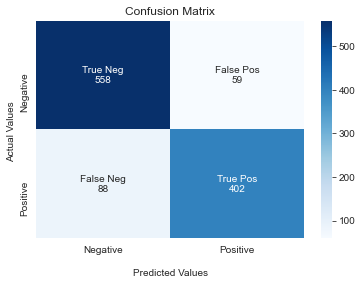

In [435]:
groups = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(val) for val in
cf_matrix.flatten()]
labels = [f"{g1}\n{g2}" for g1, g2 in
zip(groups,group_counts)]
labels = np.asarray(labels).reshape(2,2)
axes = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
axes.set_title('Confusion Matrix');
axes.set_xlabel('\nPredicted Values')
axes.set_ylabel('Actual Values ');
axes.xaxis.set_ticklabels(['Negative','Positive'])
axes.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

In [436]:
res_cfmatr = cf_matrix.flatten()
# precision = TP / (TP + FP)
precision = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[1])
precision

0.8720173535791758

In [413]:
# recall = TP / (TP + FN)
recall = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[2])
recall

0.8204081632653061

In [414]:
# f1 score = 2 * ((precision * recall)/ precision + recall)

f1score = 2 * ((precision * recall)/ precision + recall)
f1score

3.2816326530612243

## Cross Validation

In [418]:
from sklearn.model_selection import cross_val_score

In [448]:
cross_val_scores = cross_val_score(RandomForestClassifier(n_estimators=100), X, y,cv=10)

In [449]:
np.average(cross_val_scores)

0.6177204842700601